# Contact Map Analysis

### How to run:
Go to cell 2.
Replace coordinate_files with the pdb you want to test IN THIS FORMAT:

coordinate_files = \[Path To Preprocessed Coordinates.npy , Path To Simulated .h5 or .pdb File]

In [1]:
!pip install ipympl

In [2]:
#Libraries

import os
import glob
import mdtraj
from matplotlib import pyplot as plt
from matplotlib import colormaps
import matplotlib.pyplot as plt
import mplcursors  
%matplotlib widget 
import itertools
import numpy as np
from matplotlib.widgets import Slider
from matplotlib.colors import LinearSegmentedColormap

import warnings
# Define the custom colormap
colors = [
    (0, "blue"),    # Lowest value (-1)
    (0.5, "white"), # Middle value (0)
    (1, "red")      # Highest value (1)
]
custom_cmap = LinearSegmentedColormap.from_list("CustomMap", colors)

In [3]:
coordinate_files = [
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/cg_Majewski_prior_2024.07.06/6MRR/raw/coordinates.npy",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_Majewski_prior_2024.07.06_SiLU__wd0_lr2.5en4__6MRR_*.h5",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_2024.06.26_400fs_CA_lj_angle_SiLU__wd0_lr2.5en4__6MRR_*.h5",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_Majewski_prior_2024.08.03_constrain_SiLU_cutoff2__wd0_lr2.5en4__smax128__6MRR_*.h5",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_Majewski_prior_2024.08.03_constrain_tag_SiLU_cutoff2__wd0_explr1en3_0.85__smax128__6MRR_*.h5",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_Majewski_prior_2024.08.03_constrain_tag_SiLU_cutoff2__wd0_explr1en3_0.85__smax128__6MRR_*.h5"
]
'''
"/tmp/benchmark_sims_1017/2024-10-30T20:08:06.534985/BBA_0.h5",
"/media/DATA_18_TB_1/andy/benchmark_set_5/BBA/starting_pos_0/raw/starting_pos_0.pdb"

'''
coordinate_files = ["/media/DATA_14_TB/cyrusc/NERSC_data/1MHN/raw/coordinates.npy","/media/DATA_14_TB/cyrusc/NERSC_data/1M1MHN.pdb"]
#coordinate_files = ["/media/DATA_14_TB/cyrusc/NERSC_data/star2/2H09/raw/coordinates.npy","/media/DATA_14_TB/cyrusc/NERSC_data/star2/50k2H09_0.h5"]
#coordinate_files = ["/media/DATA_14_TB/cyrusc/NERSC_data/star2/2OOB/raw/coordinates.npy","/media/DATA_14_TB/cyrusc/NERSC_data/star2/50k2OOB_0.pdb"]
# Select another protein from the same set of models
#coordinate_files = [i.replace("6MRR", "3ID4") for i in coordinate_files]
#coordinate_files = [i.replace("6MRR", "2VQ4") for i in coordinate_files]

coordinate_list = []
label_list = []
subtraj_lengths_list = []

for cf in coordinate_files:
    label_list.append(os.path.basename(cf))
    batch_traj = []
    # batch_tags = []
    subtraj_lengths = []
    for subtraj in glob.glob(cf):
        if subtraj.endswith("npy"):
            coords = np.load(subtraj)
            print(len(coords))
            # Select with a stride that brings the total down to ~10,000
            if len(coords) > 10000:
                coords = coords[::(len(coords)//10000)]
            # Convert to NM to match mdtraj coordinates
            coords = coords/10
            psf_path = glob.glob(os.path.join(os.path.dirname(cf),"../processed/*_processed.psf"))[0]
            traj = mdtraj.Trajectory(coords, topology=mdtraj.formats.psf.load_psf(psf_path))
        else:
            traj = mdtraj.load(subtraj)
        batch_traj.append(traj)
        # batch_tags.append(np.repeat(len(batch_tags)+1, len(traj)))
        subtraj_lengths.append(len(traj))
    if len(batch_traj) == 0:
        print("Failed to load:", cf)
    coordinate_list.append(mdtraj.join(batch_traj))
    # traj_tags_list.append(np.concatenate(batch_tags))
    subtraj_lengths_list.append(subtraj_lengths)

assert len(coordinate_list) == len(label_list)
print(coordinate_list)

520
[<mdtraj.Trajectory with 520 frames, 59 atoms, 59 residues, without unitcells at 0x7f31b0209150>, <mdtraj.Trajectory with 1000 frames, 59 atoms, 59 residues, without unitcells at 0x7f31b0209450>]


In [4]:
def contact_map(sim_traj,inthresholds = None):
    '''
    Parameters: 
    input: any arbitrary trajectory
    output: atom x atom matrix, where ij = %of frames contacting
    threshold: distance for atoms to be considered "contacting"
    '''
    if isinstance(sim_traj, str):
        sim_traj = mdtraj.load(sim_traj)

    ca_atoms = sim_traj.topology.select("name CA")
    if inthresholds:
        thresholds= inthresholds
    else:
        thresholds = [.5,.8,1,1.2] #nm
    contact_maps = []
    all_atoms_matrix = np.array([i for i in itertools.product(ca_atoms, ca_atoms) if i[0] != i[1]])
   # print(f'all atom matrix: {all_atoms_matrix}, size = {len(all_atoms_matrix)},{len(all_atoms_matrix[0])}, Threshold: {thresholds}') ############################################## debug 
    for threshold in thresholds:
        percent_under_threshold = np.sum(mdtraj.compute_distances(sim_traj, all_atoms_matrix)<threshold,axis=0)/len(sim_traj)
        contact_maps.append(percent_under_threshold)

    return contact_maps


def visualize_map(contact_map,sim_traj):
    if isinstance(sim_traj, str):
        sim_traj = mdtraj.load(sim_traj)

    ca_atoms = sim_traj.topology.select("name CA")
    visualmatrix = np.ones([len(ca_atoms),len(ca_atoms)])
    skip = 0
    for i in range(len(ca_atoms)):
        for j in range(len(ca_atoms)):
            if i==j:
                skip +=1
                continue
            #print(i*len(ca_atoms)+j)
            visualmatrix[i][j] = contact_map[(i*len(ca_atoms))+j-skip]
    return visualmatrix,len(ca_atoms)



def contact_map_difference(simulated_contact_map, real_contact_map,sim_traj):
    scm = simulated_contact_map
    rcm = real_contact_map
    if isinstance(sim_traj, str):
        sim_traj = mdtraj.load(sim_traj)

    ca_atoms = sim_traj.topology.select("name CA")
    differencemap = np.zeros([len(ca_atoms),len(ca_atoms)])
    skip = 0
    for i in range(len(ca_atoms)):
        for j in range(len(ca_atoms)):
            if i==j:
                skip +=1
                continue
            #print(i*len(ca_atoms)+j)
            diff = ((scm[(i*len(ca_atoms))+j-skip] - rcm[(i*len(ca_atoms))+j-skip]))
            #if diff > 0: #cutoff for significant difference
            differencemap[i][j] = diff
    return differencemap,len(ca_atoms)

In [5]:
contact_maps= [contact_map(i) for i in coordinate_list] #list of each 3 contact maps for each coordinate in coordinate list
print(np.shape(contact_maps))

(2, 4, 3422)


In [6]:
cf_index_expected= 0
cf_index_model= 1

contactdiff,num = contact_map_difference(contact_maps[cf_index_expected][2],contact_maps[cf_index_model][2],coordinate_list[0])
print(np.shape(contactdiff))
smallest_threshold_value = np.min(contactdiff[np.nonzero(contactdiff)])
#print(smallest_threshold_value)

(59, 59)


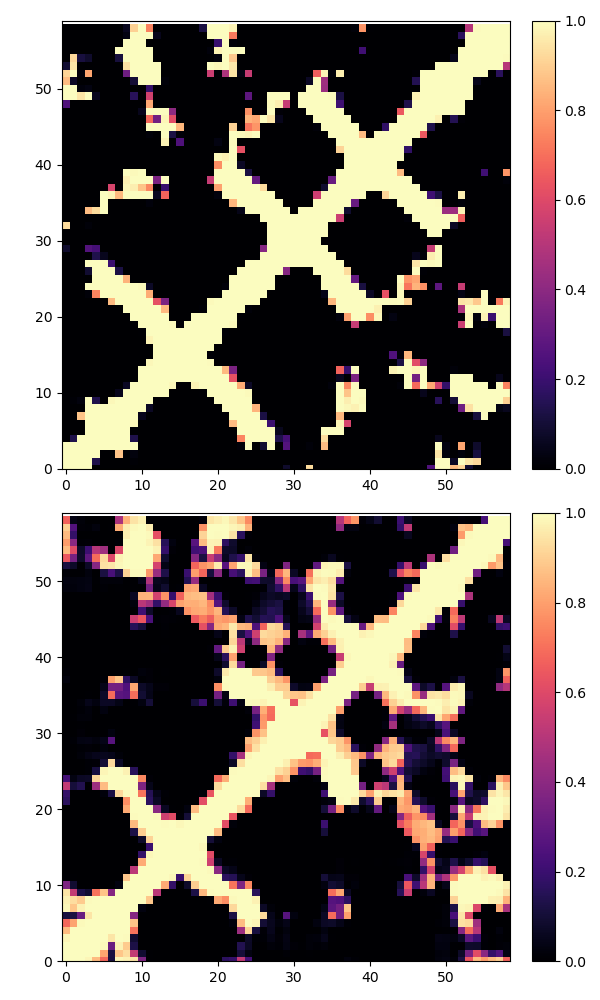

In [7]:
fig, axes = plt.subplots(len(contact_maps),1,figsize=(6,10))
for c,cf in enumerate(coordinate_files):
    matrix,atomnum = visualize_map(contact_maps[c][2],coordinate_list[c])
    #axes[c].imshow(matrix,cmap = 'magma')
    im = axes[c].imshow(matrix, cmap='magma')
    #axes[c].set_title(f"{cf}")
    axes[c].set_ylim(0,atomnum)
    fig.colorbar(im, ax=axes[c], orientation='vertical', fraction=0.046, pad=0.04)
fig.set_tight_layout(True)
#for c in range(len(coordinate_list)):
#    plt.imshow(visualize_map(contact_maps[c][2],coordinate_list[i]))

<class 'list'>


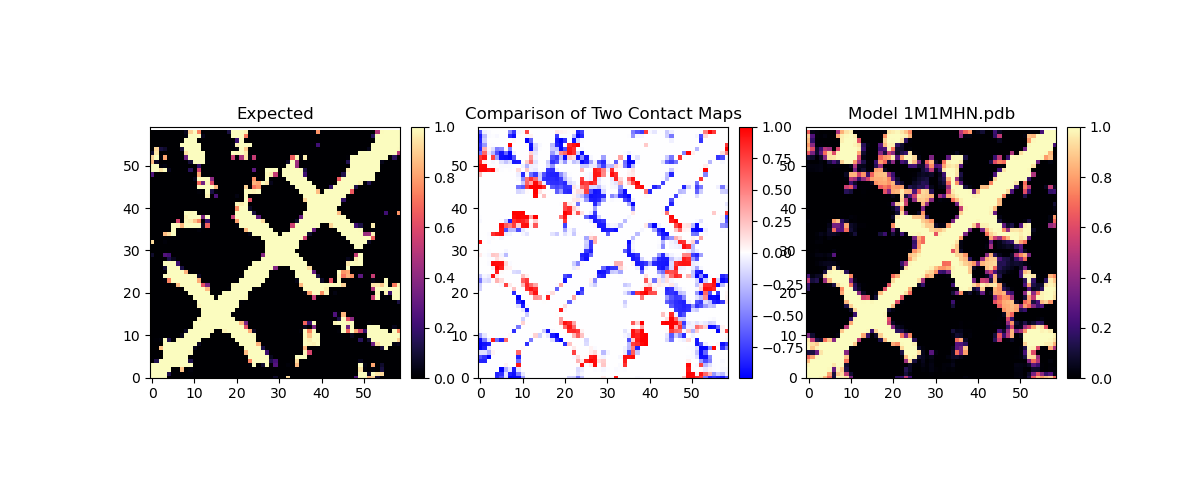

In [8]:
fig, axes = plt.subplots(1,3, figsize=(12, 5))
lenpdbid = cf[::-1].index('/')
matrix, atomnum = visualize_map(contact_maps[cf_index_expected][2], coordinate_list[0])
im = axes[0].imshow(matrix, cmap='magma')
axes[0].set_title(f"Expected")
axes[0].set_ylim(0, atomnum)
fig.colorbar(im, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

print(type(coordinate_list))
matrix, atomnum = contactdiff,num
im = axes[1].imshow(matrix,cmap=custom_cmap)
axes[1].set_title(f"Comparison of Two Contact Maps")
axes[1].set_ylim(0, atomnum)
fig.colorbar(im, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)


matrix, atomnum = visualize_map(contact_maps[cf_index_model][2], coordinate_list[0])
im = axes[2].imshow(matrix, cmap='magma')
axes[2].set_title(f"Model {cf[-lenpdbid:]}")
axes[2].set_ylim(0, atomnum)
fig.colorbar(im, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)
'''
# Highlight the highest valued cells of contactdiff in blue
max_value = np.max(contactdiff)
highlight_indices = np.where(contactdiff == max_value)

for i, j in zip(*highlight_indices):
    axes[1].scatter(j, i, color='green', s=20, edgecolor='black')
'''

# Add interactive annotation with mplcursors

cursor = mplcursors.cursor(axes[1].images, hover=False)  # Enables clicking
matrix, _ = visualize_map(contact_maps[-2][2], coordinate_list[1])  # Retrieve matrix for each plot

# Display row, col, and matrix value
cursor.connect("add", lambda sel, matrix=matrix: sel.annotation.set_text(
    f"Row: {int(sel.target[0])}, Col: {int(sel.target[1])}\n% Difference: {matrix[int(sel.target[0]), int(sel.target[1])]*100:.2f}"
    ))

plt.show()

## Blue areas indicate places where MODEL simulated CLOSER than EXPECTED
## Red areas indicate places where MODEL simulated FARTHER than EXPECTED

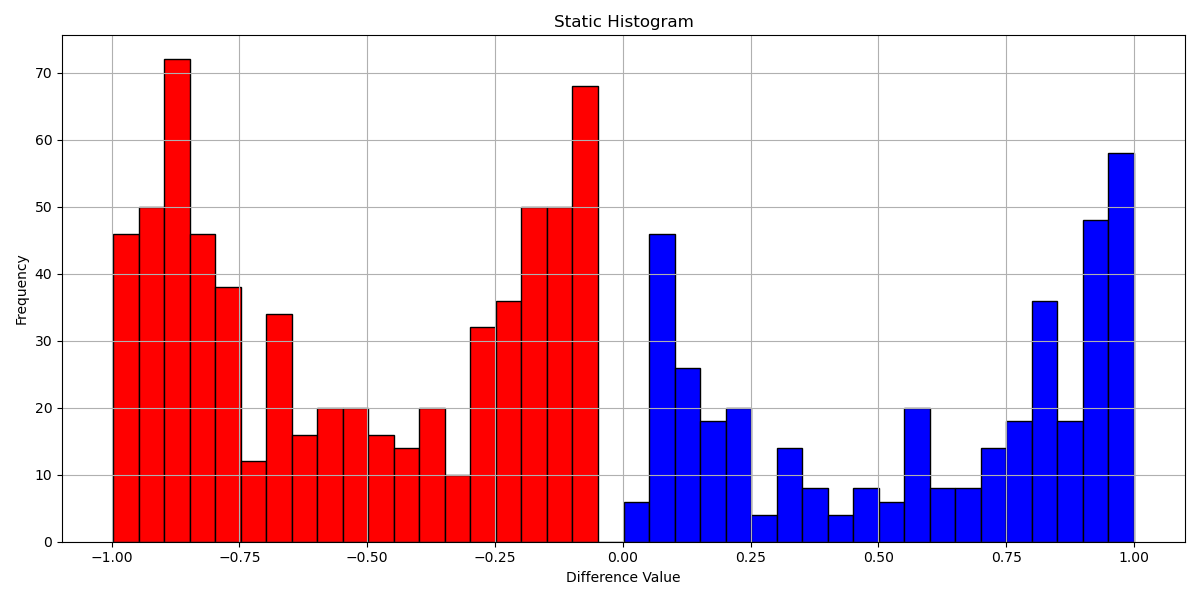

In [9]:
matrix_values = contactdiff.flatten()

# Filter out zero values
threshold_values = matrix_values[np.abs(matrix_values) >= 0.05]

# Initial percentile threshold
initial_percentile = 50
percent_threshold = np.percentile(threshold_values, initial_percentile)

# Create figure with 1x2 layout for side-by-side histograms
fig, ax_static = plt.subplots(1, 1, figsize=(12, 6))

# Static histogram on the left
n, bins, patches = ax_static.hist(threshold_values, bins=40, edgecolor='black')

# Color the bars based on the specified value ranges
for patch, value in zip(patches, bins):
    if value < 0:
        patch.set_facecolor('red')
    elif value > 0:
        patch.set_facecolor('blue')


static_threshold = np.percentile(threshold_values, 50)  # Static threshold at 50th percentile
#ax_static.legend(['Blue: Closer than expected', 'Red: Farther than expected'], loc='upper left')
#ax_static.axvline(x=static_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Closer ({static_threshold:.2f})')
#ax_static.axvline(x=0.82, color='red', linestyle='dashed', linewidth=2, label=f'Missing structures (0.82)')
#ax_static.legend(loc='upper left')
ax_static.set_title('Static Histogram')
ax_static.set_xlabel('Difference Value')
ax_static.set_ylabel('Frequency')
#ax_static.legend(loc='upper right')
ax_static.grid(True)
plt.tight_layout()
plt.show()


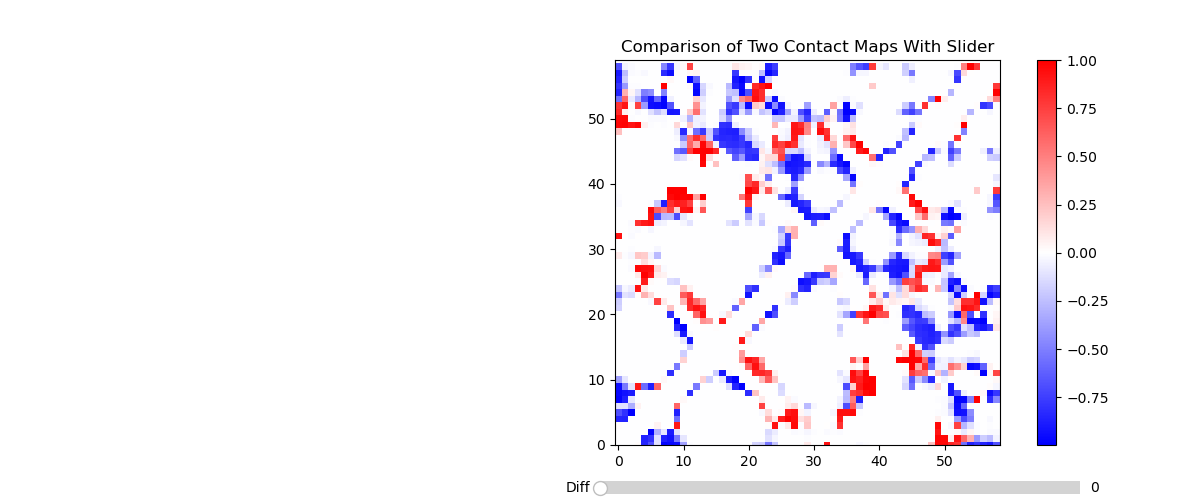

In [10]:



fig, axes = plt.subplots(1, 1, figsize=(12, 5))
matrix, atomnum = contactdiff, num
global diff
diff = 0
matrix_display = np.where(np.abs(matrix) > diff, matrix, 0)
im = axes.imshow(matrix_display, cmap=custom_cmap)
axes.set_title(f"Comparison of Two Contact Maps With Slider")

# Slider for the diff value
ax_diff_slider = plt.axes([0.25, 0.01, 0.65, 0.03], facecolor='lightgoldenrodyellow')
diff_slider = Slider(ax_diff_slider, 'Diff', 0, np.max(contactdiff), valinit=diff)
ax_diff_slider.set_position([0.5, 0, 0.4, 0.05])  # [left, bottom, width, height]
# Update function for the slider
def update_diff(val):
    diff = diff_slider.val
    matrix_display = np.where(np.abs(matrix) > diff, matrix, 0)
    im.set_data(matrix_display)
    fig.canvas.draw_idle()

# Connect slider to the update function
diff_slider.on_changed(update_diff)
axes.set_ylim(0, atomnum)
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.046, pad=0.04)

plt.show()


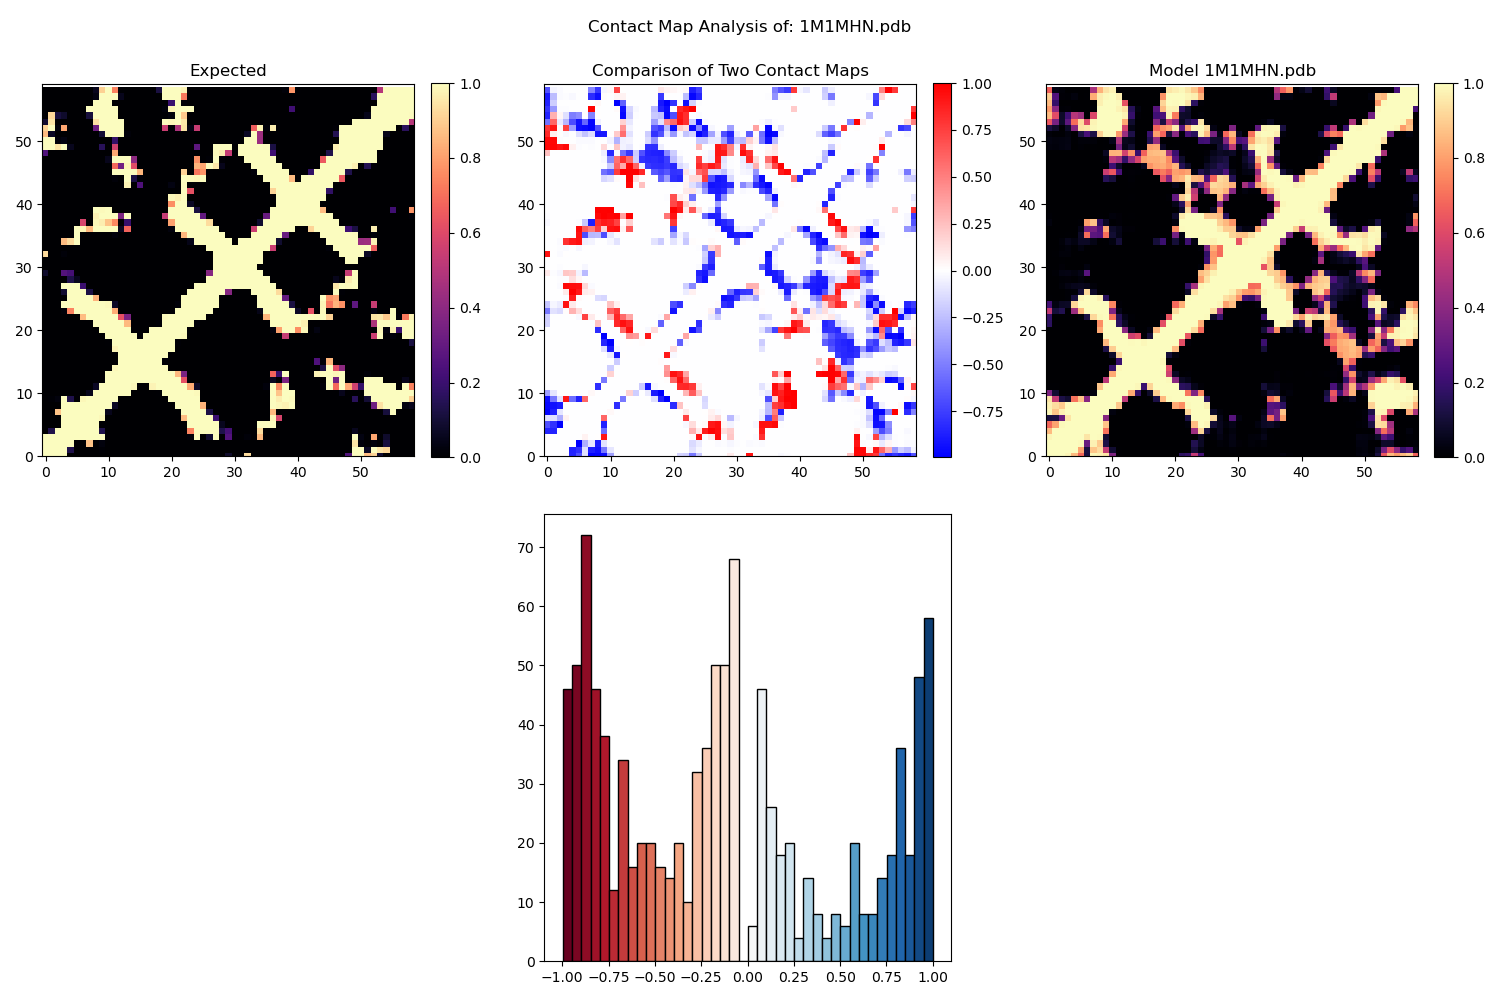

In [18]:
from matplotlib.widgets import Slider
import matplotlib.pyplot as plt
import numpy as np
import mplcursors

cf_index_expected = 0
cf_index_model = 1

# Create a single figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f"Contact Map Analysis of: {coordinate_files[cf_index_model][-lenpdbid:]}")

# First subplot: Expected Contact Map
Ematrix, atomnum = visualize_map(contact_maps[cf_index_expected][2], coordinate_list[0])
im = axes[0, 0].imshow(Ematrix, cmap='magma')
axes[0, 0].set_title("Expected")
axes[0, 0].set_ylim(0, atomnum)
fig.colorbar(im, ax=axes[0, 0], orientation='vertical', fraction=0.046, pad=0.04)

# Second subplot: Comparison of Two Contact Maps
Cmatrix, atomnum = contactdiff, num
im = axes[0, 1].imshow(Cmatrix, cmap=custom_cmap)
axes[0, 1].set_title("Comparison of Two Contact Maps")
axes[0, 1].set_ylim(0, atomnum)
fig.colorbar(im, ax=axes[0, 1], orientation='vertical', fraction=0.046, pad=0.04)

# Third subplot: Model Contact Map
matrix, atomnum = visualize_map(contact_maps[cf_index_model][2], coordinate_list[0])
im = axes[0, 2].imshow(matrix, cmap='magma')
axes[0, 2].set_title(f"Model {cf[-lenpdbid:]}")
axes[0, 2].set_ylim(0, atomnum)
fig.colorbar(im, ax=axes[0, 2], orientation='vertical', fraction=0.046, pad=0.04)

# Fourth subplot: Static Histogram
matrix_values = contactdiff.flatten()
threshold_values = matrix_values[np.abs(matrix_values) >= 0.05]
initial_percentile = 50
percent_threshold = np.percentile(threshold_values, initial_percentile)
n, bins, patches = axes[1, 1].hist(threshold_values, bins=40, edgecolor='black')

# Color the bars based on a gradient from red at -1, white at 0, and blue at 1
for patch, value in zip(patches, bins):
    if value < 0:
        color = plt.cm.RdBu_r((-value + 1) / 2)  # Normalize value to range [0, 1]
    else:
        color = plt.cm.RdBu_r((-value + 1) / 2)  # Normalize value to range [0, 1]
    patch.set_facecolor(color)

'''
static_threshold = np.percentile(threshold_values, 52)
axes[1, 1].legend(loc='upper left')
axes[1, 1].set_title('Static Histogram')
axes[1, 1].set_xlabel('Difference Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)
'''
# Hide the empty subplots
axes[1, 0].axis('off')
axes[1, 2].axis('off')

# Add interactive annotation with mplcursors
cursor = mplcursors.cursor(axes[0, 1].images, hover=False)
matrix, _ = visualize_map(contact_maps[-2][2], coordinate_list[1])
cursor.connect("add", lambda sel, matrix=matrix: sel.annotation.set_text(
    f"Row: {int(sel.target[0])}, Col: {int(sel.target[1])}\n% Difference: {matrix[int(sel.target[0]), int(sel.target[1])]*100:.2f}"
))

plt.tight_layout()
plt.show()


In [12]:
# Load the trajectory from the h5 file
traj = mdtraj.load("/media/DATA_14_TB/cyrusc/NERSC_data/star2/50k2H09_0.h5")

# Save the trajectory to a pdb file
traj.save("/media/DATA_14_TB/cyrusc/NERSC_data/star2/50k2H09_0.pdb")

/home/md-ml/miniconda3/envs/cyrusc-torchmdnet2/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [13]:
import nglview as nv

# Load the model and expected trajectories
view = nv.show_mdtraj(coordinate_list[cf_index_model])
view.add_trajectory(nv.MDTrajTrajectory(coordinate_list[cf_index_expected]))

# Set the size of the NGL widget
view._remote_call('setSize', target='Widget', args=['800px', '800px'])

# Add cartoon representation to include beta sheets and coils
view.add_cartoon(color='sstruc')

# Set the expected protein color to neon pink
view.update_cartoon(color='hotpink', component=1)

# Display the interactive view
view

NGLWidget(max_frame=999)